In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [2]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


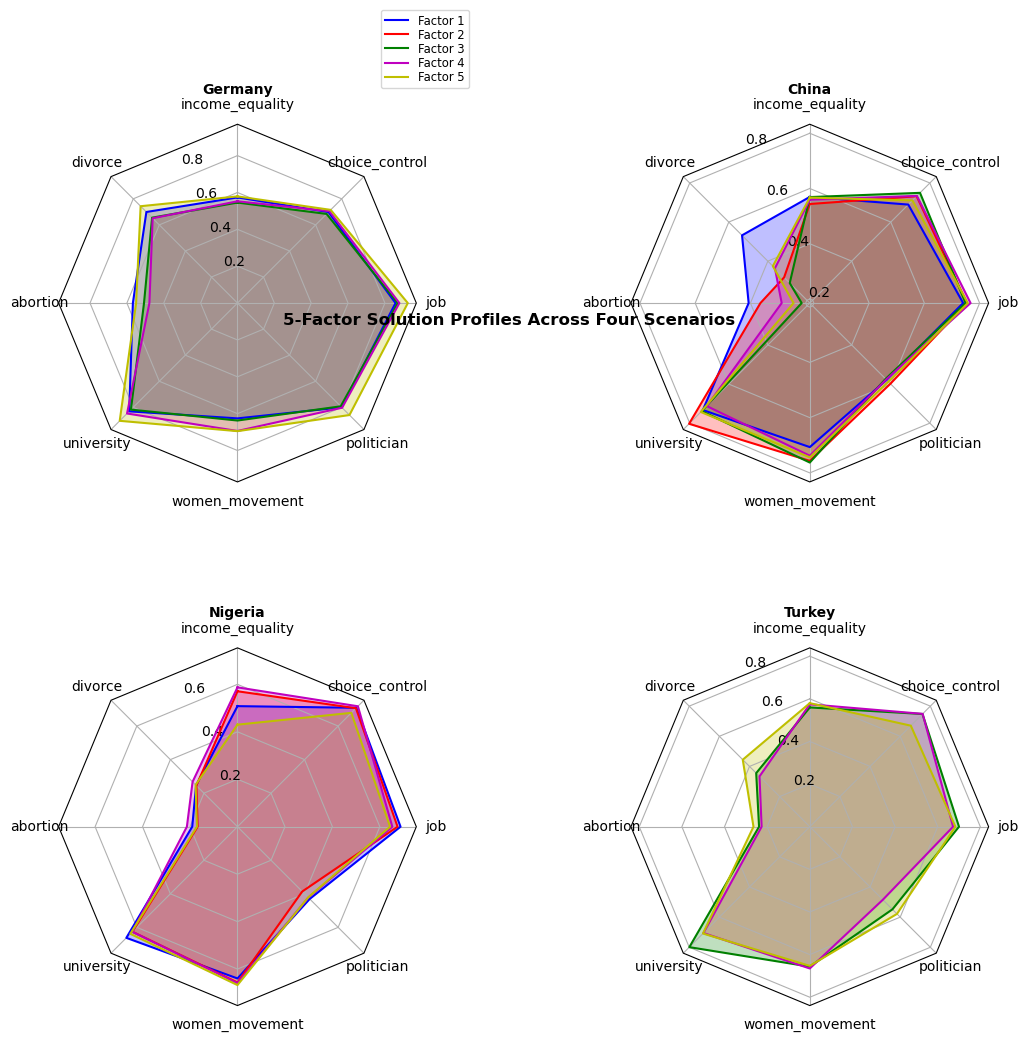

In [9]:



def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolyzed Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [['income_equality', 'divorce', 'abortion', 'university', 'women_movement', 'politician', 'job', 'choice_control'], ('Germany', [[0.5732394366197183, 0.6990023474178404, 0.5676056338028169, 0.830868544600939, 0.6257335680751174, 0.8002347417840376, 0.85768779342723, 0.6984154929577465], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5452631578947369, 0.6552631578947368, 0.5071710526315789, 0.8175000000000001, 0.6373355263157895, 0.7922368421052631, 0.8692434210526315, 0.684078947368421], [0.5522914218566393, 0.6509400705052879, 0.477967097532315, 0.8474735605170387, 0.6940364277320799, 0.8030552291421857, 0.8785252643948296, 0.7051703877790835], [0.5788413098236775, 0.7432409739714526, 0.5500419815281277, 0.9036104114189756, 0.6950041981528128, 0.8592779177162049, 0.9242233417296389, 0.7151973131821998]]), ('China', [[0.5695568400770713, 0.5320809248554913, 0.4065510597302505, 0.7327552986512524, 0.7066473988439307, 0.5786127167630057, 0.7403660886319846, 0.6894990366088632], [0.543859649122807, 0.3167341430499325, 0.3639676113360324, 0.8032388663967611, 0.7564102564102564, 0.5981106612685559, 0.7540485829959515, 0.7322537112010796], [0.5689655172413792, 0.2878817733990148, 0.21467980295566505, 0.7385221674876847, 0.7625615763546798, 0.5733990147783251, 0.7492610837438424, 0.7495566502463055], [0.5594238683127573, 0.3637037037037037, 0.2869135802469136, 0.7125925925925926, 0.7378600823045267, 0.5764609053497942, 0.7672839506172839, 0.7338271604938271], [0.5670050761421319, 0.37451776649746193, 0.24402707275803723, 0.7429441624365483, 0.7437394247038918, 0.5875465313028765, 0.7571912013536379, 0.71082910321489]]), ('Nigeria', [[0.5081867798665858, 0.24651303820497272, 0.1907216494845361, 0.6624620982413584, 0.6396300788356579, 0.430563978168587, 0.6872346876895088, 0.7087932080048513], [0.5708565072302558, 0.2449944382647386, 0.167853170189099, 0.6261401557285873, 0.6567018909899889, 0.3860956618464961, 0.6747775305895439, 0.7061735261401557], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.587322342239909, 0.26759522455940876, 0.21324616259238205, 0.6267197271176805, 0.6591813530415008, 0.4223990903922683, 0.6526435474701535, 0.7179079022171688], [0.4300798580301686, 0.24960070984915705, 0.17089618456078084, 0.6386867790594499, 0.6674800354924578, 0.4212954747116238, 0.6430789707187222, 0.6787045252883762]]), ('Turkey', [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5595426561125769, 0.355584872471416, 0.23799472295514512, 0.7991204925241864, 0.6565523306948109, 0.5482849604221636, 0.7000879507475813, 0.7478452066842568], [0.574300441826215, 0.33372606774668634, 0.2259941089837997, 0.7054491899852724, 0.6651325478645066, 0.4846833578792341, 0.6723122238586157, 0.7487481590574374], [0.5797348484848485, 0.44460227272727276, 0.264157196969697, 0.7087121212121212, 0.6529356060606061, 0.5785037878787879, 0.6831202651515151, 0.6703598484848484]])]


    data2 = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO'],
        ('Basecase', [
            [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00]])
    ]
    return data


if __name__ == '__main__':
    N = 8
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(12, 12), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.6, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = axs[0,0].legend(labels, loc=(0.9, 1.1),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.65, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()